In [2]:
import glob
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import sys
from tqdm.auto import tqdm
import yaml

pd.options.display.float_format = '{:.3f}'.format
sns.set_style("whitegrid")
sys.path.append('..')

#### Parse results

In [3]:
result_files = glob.glob('./results/*.yml')
results = {}
times = {}
for fp in tqdm(result_files):
    exp_name = os.path.basename(fp)
    ds_name = exp_name.split('__')[0]
    if ds_name not in results:
        results[ds_name] = {}
    if ds_name not in times:
        times[ds_name] = {}
    m_name = '_'.join(exp_name.split('__')[1:-1])
    if m_name not in results[ds_name]:
        results[ds_name][m_name] = []
    if m_name not in times[ds_name]:
        times[ds_name][m_name] = []
    run_id = exp_name.split('__')[-1]
    with open(fp, 'r') as f:
        res = yaml.load(f, yaml.SafeLoader)
    if res is not None:
        results[ds_name][m_name].append(res['results']['acc_test'])
        times[ds_name][m_name].append(res['results']['elapsed'])

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 732/732 [00:04<00:00, 175.32it/s]


#### Organize results

In [4]:
results_mean = {ds_name: {m_name: np.mean(results[ds_name][m_name]) for m_name in results[ds_name]} for ds_name in results}
results_std = {ds_name: {m_name: np.std(results[ds_name][m_name]) for m_name in results[ds_name]} for ds_name in results}
results_str = {ds_name: {m_name: f'{results_mean[ds_name][m_name]:.3f} ({results_std[ds_name][m_name]:.3f})' for m_name in results[ds_name]} for ds_name in results}

In [5]:
small_ds = ['ArticularyWordRecognition',
            'AtrialFibrillation',
            'BasicMotions',
            'Cricket',
            'DuckDuckGeese',
            'ERing',
            'EigenWorms',
            'Epilepsy',
            'EthanolConcentration',
            'FingerMovements',
            'HandMovementDirection',
            'Handwriting',
            'Heartbeat',
            'JapaneseVowels',
            'Libras',
            'MotorImagery',
            'NATOPS',
            'PEMS-SF',
            'RacketSports',
            'SelfRegulationSCP1',
            'SelfRegulationSCP2',
            'StandWalkJump',
            'UWaveGestureLibrary']

large_ds = ['CharacterTrajectories', 
            'FaceDetection',
            'InsectWingbeat',
            'LSST',
            'PenDigits',
            'PhonemeSpectra',
            'SpokenArabicDigits',
            'fNIRS2MW',
            'SITS1M']

In [7]:
df = pd.DataFrame.from_dict(results_mean, orient='index')
df = df.sort_index().reindex(sorted(df.columns), axis=1)

In [8]:
# Reorganize and rename columns.
df = df[['rfsf_dp_200', 'rfsf_trp_200', 'ksig_r_200', 'ksig_pde_200', 'rws_200', 'gak_200', 'rbf_200', 'rff_200']]
df = df.rename(columns={'rfsf_dp_200': 'RFSF-DP', 'rfsf_trp_200': 'RFSF-TRP', 'ksig_r_200': 'KSig',
                        'ksig_pde_200': 'KSigPDE', 'gak_200': 'GAK', 'rbf_200': 'RBF', 'rff_200': 'RFF', 'rws_200': 'RWS'})

In [9]:
df_str = pd.DataFrame.from_dict(results_str, orient='index')
df_str = df_str.sort_index().reindex(sorted(df_str.columns), axis=1)
df_str = df_str[['rfsf_dp_200', 'rfsf_trp_200', 'ksig_r_200', 'ksig_pde_200', 'rws_200', 'gak_200', 'rbf_200', 'rff_200']]
df_str = df_str.rename(columns={'rfsf_dp_200': 'RFSF-DP', 'rfsf_trp_200': 'RFSF-TRP', 'ksig_r_200': 'KSig', 
                                'ksig_pde_200': 'KSigPDE', 'gak_200': 'GAK', 'rbf_200': 'RBF', 'rff_200': 'RFF', 'rws_200': 'RWS'})
df_str_small = df_str.loc[small_ds]

In [10]:
results_array = df.values
best = df.index[np.argmax(df.values, axis=1)]

In [11]:
def decimals(value):
    new_value = f'{float(value):.03f}' if '(' not in str(value) and 'mathbf' not in str(value) and not 'mathit' in str(value) else value
    return new_value

def highlight_max(data):
    means = np.asarray([float(str(v).split('(')[0]) for v in data.values])
    stds = np.asarray([float(str(v).split('(')[1].rstrip(')')) if len(str(v).split('(')) > 1 else '' for v in data.values])
    ordered = sorted(np.unique(means))
    is_first = means == ordered[-1]
    if len(ordered) == 1:
        is_second = [False for _ in is_first]
    else:
        is_second = means == ordered[-2]
    new_means = [f'\\mathbf{{{v:.03f}}}' if is_first[i] else f'\\mathit{{{v:.03f}}}' if is_second[i] else f'{v:.03f}' for i, v in enumerate(means)]
    new_values = [f'{v}({float(stds[i]):.03f})' if stds[i] != '' else v for i, v in enumerate(new_means)]
    return pd.Series(new_values)

def latex_dollar(value):
    new_value = f'\${value}\$'
    return new_value

In [12]:
df_small = df.loc[small_ds]
small_ranks = df_small.rank(axis=1, method='dense', ascending=False)
small_avg_rank = small_ranks.mean(axis=0).round(3)
df_small_avg = df_small.mean(axis=0).round(3)

idx = {i: ds_name for i, ds_name in enumerate(sorted(list(small_ds)))}

idx[len(df_small.index)] = 'Avg.acc.'
idx[len(df_small.index)+1] = 'Avg.rank'

df_small = df_small.append(df_small_avg, ignore_index=True).append(small_avg_rank, ignore_index=True).rename(index=idx)
df_small = df_small.apply(highlight_max, axis=1).applymap(decimals).applymap(latex_dollar)
df_small = df_small.rename(columns={i:df.columns[i] for i, _ in enumerate(df_small.columns)})
df_small = df_small.rename(index=idx)

display(df_small)

# df = df.apply(highlight_max, axis=1).rename(columns={i:c for i, c in enumerate(df.columns)})
# df = df.append(df_avg, ignore_index=True).append(df_median, ignore_index=True).append(df_sd, ignore_index=True).append(avg_rank, ignore_index=True).append(med_rank, ignore_index=True).append(sd_rank, ignore_index=True)
# df = df.applymap(decimals).applymap(latex_dollar)
# df = df.rename(index=idx)
# display(df)

/tmp/ipykernel_2652158/475892260.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_small = df_small.append(df_small_avg, ignore_index=True).append(small_avg_rank, ignore_index=True).rename(index=idx)
/tmp/ipykernel_2652158/475892260.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_small = df_small.append(df_small_avg, ignore_index=True).append(small_avg_rank, ignore_index=True).rename(index=idx)


,RFSF-DP,RFSF-TRP,KSig,KSigPDE,RWS,GAK,RBF,RFF
ArticularyWordRecognition,\$0.984\$,\$0.981\$,\$\mathbf{0.990}\$,\$0.983\$,\$\mathit{0.987}\$,\$0.977\$,\$0.977\$,\$0.978\$
AtrialFibrillation,\$0.373\$,\$0.320\$,\$\mathit{0.400}\$,\$0.333\$,\$\mathbf{0.427}\$,\$0.333\$,\$0.267\$,\$0.373\$
BasicMotions,\$\mathbf{1.000}\$,\$\mathbf{1.000}\$,\$\mathbf{1.000}\$,\$\mathbf{1.000}\$,\$\mathit{0.995}\$,\$\mathbf{1.000}\$,\$0.975\$,\$0.860\$
Cricket,\$0.964\$,\$0.964\$,\$0.958\$,\$\mathit{0.972}\$,\$\mathbf{0.978}\$,\$0.944\$,\$0.917\$,\$0.886\$
DuckDuckGeese,\$0.636\$,\$\mathit{0.664}\$,\$\mathbf{0.700}\$,\$0.480\$,\$0.492\$,\$0.500\$,\$0.420\$,\$0.372\$
ERing,\$0.921\$,\$0.936\$,\$0.841\$,\$\mathit{0.941}\$,\$\mathbf{0.945}\$,\$0.926\$,\$0.937\$,\$0.915\$
EigenWorms,\$\mathit{0.817}\$,\$\mathbf{0.837}\$,\$0.809\$,\$0.794\$,\$0.623\$,\$0.511\$,\$0.496\$,\$0.443\$
Epilepsy,\$\mathit{0.949}\$,\$0.942\$,\$\mathbf{0.949}\$,\$0.891\$,\$0.925\$,\$0.870\$,\$0.891\$,\$0.777\$
EthanolConcentration,\$0.457\$,\$0.439\$,\$\mathbf{0.479}\$,\$\mathit{0.460}\$,\$0.284\$,\$0.361\$,\$0.346\$,\$0.325\$
FingerMovements,\$0.608\$,\$0.624\$,\$\mathbf{0.640}\$,\$\mathit{0.630}\$,\$0.612\$,\$0.500\$,\$0.620\$,\$0.570\$


##### CD diagram

In [15]:
"""
CD Diagrams were proposed as a method for visualization of Bonferroni-Dunn
post hoc test in Demsar, J. (2006) Statistical Comparisons of Classifiers
over Multiple Data Sets. Journal of Machine Learning Research, 7, 1-30.
I would, however, recommend moving on, to better, Bayesian methods for comparison
of classifiers. See https://www.jmlr.org/papers/volume18/16-305/16-305.pdf
for an introduction and https://pypi.org/project/baycomp/ for a package that
implements the necessary functions.
This code was removed from Orange 3.34 (https://github.com/biolab/orange3),
so I moved it here if anybody finds it useful (though (s)he should not).
The code was originally written by @nikicc, with later minor contributions
by @janezd and @Zagar.
"""

import math

import numpy as np

import matplotlib.pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvasAgg


def compute_CD(avranks, n, alpha=0.05, test="nemenyi"):
    """
    Returns critical difference for Nemenyi or Bonferroni-Dunn test
    according to given alpha (either alpha="0.05" or alpha="0.1") for average
    ranks and number of tested datasets N. Test can be either "nemenyi" for
    for Nemenyi two tailed test or "bonferroni-dunn" for Bonferroni-Dunn test.
    Args:
	avranks (int or list): list of average ranks or the number of methods
	n (int): number of data sets
	alpha (float): alpha level; must be either 0.05 or 0.1
	test (str): "nemenyi" or "bonferroni-dunn"
    """
    k = avranks if isinstance(avranks, int) else len(avranks)
    d = {("nemenyi", 0.05): [0, 0, 1.959964, 2.343701, 2.569032, 2.727774,
                               2.849705, 2.94832, 3.030879, 3.101730, 3.163684,
                               3.218654, 3.268004, 3.312739, 3.353618, 3.39123,
                               3.426041, 3.458425, 3.488685, 3.517073,
                               3.543799],
         ("nemenyi", 0.1): [0, 0, 1.644854, 2.052293, 2.291341, 2.459516,
                              2.588521, 2.692732, 2.779884, 2.854606, 2.919889,
                              2.977768, 3.029694, 3.076733, 3.119693, 3.159199,
                              3.195743, 3.229723, 3.261461, 3.291224, 3.319233],
         ("bonferroni-dunn", 0.05): [0, 0, 1.960, 2.241, 2.394, 2.498, 2.576,
                                       2.638, 2.690, 2.724, 2.773],
         ("bonferroni-dunn", 0.1): [0, 0, 1.645, 1.960, 2.128, 2.241, 2.326,
                                      2.394, 2.450, 2.498, 2.539]}
    q = d[(test, alpha)]
    cd = q[k] * (k * (k + 1) / (6.0 * n)) ** 0.5
    return cd


def graph_ranks(avranks, names, cd=None, cdmethod=None, lowv=None, highv=None,
                width=6, textspace=1, reverse=False, filename=None, **kwargs):
    """
    Draws a CD graph, which is used to display  the differences in methods'
    performance. See Janez Demsar, Statistical Comparisons of Classifiers over
    Multiple Data Sets, 7(Jan):1--30, 2006.
    Needs matplotlib to work.
    The image is ploted on `plt` imported using `import matplotlib.pyplot as plt`.
    Args:
        avranks (list of float): average ranks of methods.
        names (list of str): names of methods.
        cd (float): Critical difference used for statistically significance of
            difference between methods.
        cdmethod (int, optional): the method that is compared with other methods
            If omitted, show pairwise comparison of methods
        lowv (int, optional): the lowest shown rank
        highv (int, optional): the highest shown rank
        width (int, optional): default width in inches (default: 6)
        textspace (int, optional): space on figure sides (in inches) for the
            method names (default: 1)
        reverse (bool, optional):  if set to `True`, the lowest rank is on the
            right (default: `False`)
        filename (str, optional): output file name (with extension). If not
            given, the function does not write a file.
    """
    width = float(width)
    textspace = float(textspace)

    def nth(l, n):
        """
        Returns only nth elemnt in a list.
        """
        n = lloc(l, n)
        return [a[n] for a in l]

    def lloc(l, n):
        """
        List location in list of list structure.
        Enable the use of negative locations:
        -1 is the last element, -2 second last...
        """
        if n < 0:
            return len(l[0]) + n
        else:
            return n

    def mxrange(lr):
        """
        Multiple xranges. Can be used to traverse matrices.
        This function is very slow due to unknown number of
        parameters.
        >>> mxrange([3,5])
        [(0, 0), (0, 1), (0, 2), (1, 0), (1, 1), (1, 2)]
        >>> mxrange([[3,5,1],[9,0,-3]])
        [(3, 9), (3, 6), (3, 3), (4, 9), (4, 6), (4, 3)]
        """
        if not len(lr):
            yield ()
        else:
            # it can work with single numbers
            index = lr[0]
            if isinstance(index, int):
                index = [index]
            for a in range(*index):
                for b in mxrange(lr[1:]):
                    yield tuple([a] + list(b))

    def print_figure(fig, *args, **kwargs):
        canvas = FigureCanvasAgg(fig)
        canvas.print_figure(*args, **kwargs)

    sums = avranks

    tempsort = sorted([(a, i) for i, a in enumerate(sums)], reverse=reverse)
    ssums = nth(tempsort, 0)
    sortidx = nth(tempsort, 1)
    nnames = [names[x] for x in sortidx]

    if lowv is None:
        lowv = min(1, int(math.floor(min(ssums))))
    if highv is None:
        highv = max(len(avranks), int(math.ceil(max(ssums))))

    cline = 0.4

    k = len(sums)

    lines = None

    linesblank = 0
    scalewidth = width - 2 * textspace

    def rankpos(rank):
        if not reverse:
            a = rank - lowv
        else:
            a = highv - rank
        return textspace + scalewidth / (highv - lowv) * a

    distanceh = 0.25

    if cd and cdmethod is None:
        # get pairs of non significant methods

        def get_lines(sums, hsd):
            # get all pairs
            lsums = len(sums)
            allpairs = [(i, j) for i, j in mxrange([[lsums], [lsums]]) if j > i]
            # remove not significant
            notSig = [(i, j) for i, j in allpairs
                      if abs(sums[i] - sums[j]) <= hsd]
            # keep only longest

            def no_longer(ij_tuple, notSig):
                i, j = ij_tuple
                for i1, j1 in notSig:
                    if (i1 <= i and j1 > j) or (i1 < i and j1 >= j):
                        return False
                return True

            longest = [(i, j) for i, j in notSig if no_longer((i, j), notSig)]

            return longest

        lines = get_lines(ssums, cd)
        linesblank = 0.2 + 0.2 + (len(lines) - 1) * 0.1

        # add scale
        distanceh = 0.25
        cline += distanceh

    # calculate height needed height of an image
    minnotsignificant = max(2 * 0.2, linesblank)
    height = cline + ((k + 1) / 2) * 0.2 + minnotsignificant

    fig = plt.figure(figsize=(width, height))
    fig.set_facecolor('white')
    ax = fig.add_axes([0, 0, 1, 1])  # reverse y axis
    ax.set_axis_off()

    hf = 1. / height  # height factor
    wf = 1. / width

    def hfl(l):
        return [a * hf for a in l]

    def wfl(l):
        return [a * wf for a in l]


    # Upper left corner is (0,0).
    ax.plot([0, 1], [0, 1], c="w")
    ax.set_xlim(0, 1)
    ax.set_ylim(1, 0)

    def line(l, color='k', **kwargs):
        """
        Input is a list of pairs of points.
        """
        ax.plot(wfl(nth(l, 0)), hfl(nth(l, 1)), color=color, **kwargs)

    def text(x, y, s, *args, **kwargs):
        ax.text(wf * x, hf * y, s, *args, **kwargs)

    line([(textspace, cline), (width - textspace, cline)], linewidth=0.7)

    bigtick = 0.1
    smalltick = 0.05

    tick = None
    for a in list(np.arange(lowv, highv, 0.5)) + [highv]:
        tick = smalltick
        if a == int(a):
            tick = bigtick
        line([(rankpos(a), cline - tick / 2),
              (rankpos(a), cline)],
             linewidth=0.7)

    for a in range(lowv, highv + 1):
        text(rankpos(a), cline - tick / 2 - 0.05, str(a),
             ha="center", va="bottom")

    k = len(ssums)

    for i in range(math.ceil(k / 2)):
        chei = cline + minnotsignificant + i * 0.2
        line([(rankpos(ssums[i]), cline),
              (rankpos(ssums[i]), chei),
              (textspace - 0.1, chei)],
             linewidth=0.7)
        text(textspace - 0.2, chei, nnames[i], ha="right", va="center")

    for i in range(math.ceil(k / 2), k):
        chei = cline + minnotsignificant + (k - i - 1) * 0.2
        line([(rankpos(ssums[i]), cline),
              (rankpos(ssums[i]), chei),
              (textspace + scalewidth + 0.1, chei)],
             linewidth=0.7)
        text(textspace + scalewidth + 0.2, chei, nnames[i],
             ha="left", va="center")

    if cd and cdmethod is None:
        # upper scale
        if not reverse:
            begin, end = rankpos(lowv), rankpos(lowv + cd)
        else:
            begin, end = rankpos(highv), rankpos(highv - cd)

        line([(begin, distanceh), (end, distanceh)], linewidth=0.7)
        line([(begin, distanceh + bigtick / 2),
              (begin, distanceh - bigtick / 2)],
             linewidth=0.7)
        line([(end, distanceh + bigtick / 2),
              (end, distanceh - bigtick / 2)],
             linewidth=0.7)
        text((begin + end) / 2, distanceh - 0.05, "CD",
             ha="center", va="bottom")

        # no-significance lines
        def draw_lines(lines, side=0.05, height=0.1):
            start = cline + 0.2
            for l, r in lines:
                line([(rankpos(ssums[l]) - side, start),
                      (rankpos(ssums[r]) + side, start)],
                     linewidth=2.5)
                start += height

        draw_lines(lines)

    elif cd:
        begin = rankpos(avranks[cdmethod] - cd)
        end = rankpos(avranks[cdmethod] + cd)
        line([(begin, cline), (end, cline)],
             linewidth=2.5)
        line([(begin, cline + bigtick / 2),
              (begin, cline - bigtick / 2)],
             linewidth=2.5)
        line([(end, cline + bigtick / 2),
              (end, cline - bigtick / 2)],
             linewidth=2.5)

    if filename:
        print_figure(fig, filename, **kwargs)

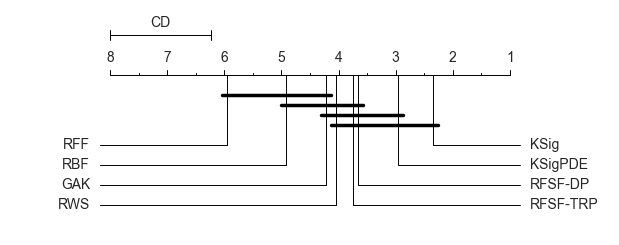

In [17]:
plots_dir = './plots/'
if not os.path.exists(plots_dir):
    os.mkdir(plots_dir)
cd_diagram_fp = os.path.join(plots_dir, 'cd_diagram.pdf')

cd = compute_CD(small_avg_rank, len(small_ds), alpha=0.1, test='bonferroni-dunn')
graph_ranks(small_avg_rank, df.columns, cd=cd, width=6, textspace=1, reverse=True, filename=cd_diagram_fp)

In [18]:
df.loc[large_ds]

,RFSF-DP,RFSF-TRP,KSig,KSigPDE,RWS,GAK,RBF,RFF
CharacterTrajectories,0.990,0.990,NaN,NaN,0.991,NaN,NaN,0.989
FaceDetection,0.653,0.656,NaN,NaN,0.642,NaN,NaN,0.572
InsectWingbeat,0.436,0.459,NaN,NaN,0.227,NaN,NaN,0.341
LSST,0.589,0.624,NaN,NaN,0.631,NaN,NaN,0.423
PenDigits,0.983,0.982,NaN,NaN,0.989,NaN,NaN,0.980
PhonemeSpectra,0.204,0.204,NaN,NaN,0.205,NaN,NaN,0.083
SpokenArabicDigits,0.981,0.980,NaN,NaN,0.981,NaN,NaN,0.964
fNIRS2MW,0.659,0.658,NaN,NaN,0.621,NaN,NaN,0.642
SITS1M,0.745,0.740,NaN,NaN,0.610,NaN,NaN,0.718


In [20]:
df_large = df.loc[large_ds]
df_large = df_large[['RFSF-DP', 'RFSF-TRP', 'RWS', 'RFF']].round(3)
large_ranks = df_large.rank(axis=1, method='dense', ascending=False)
large_avg_rank = large_ranks.mean(axis=0)
df_large_avg = df_large.mean(axis=0)
df_large = df_large.sort_index()

idx = {i: ds_name for i, ds_name in enumerate(df_large.index)}

idx[len(df_large.index)] = 'Avg.acc.'
idx[len(df_large.index)+1] = 'Avg.rank'

df_large = df_large.append(df_large_avg, ignore_index=True).append(large_avg_rank, ignore_index=True).rename(index=idx)
df_large = df_large.apply(highlight_max, axis=1).applymap(decimals).applymap(latex_dollar)
df_large = df_large.rename(columns={0: 'RFSF-DP', 1: 'RFSF-TRP', 2: 'RWS', 3: 'RFF'})
df_large = df_large.rename(index=idx)

display(df_large)

/tmp/ipykernel_2652158/893128966.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_large = df_large.append(df_large_avg, ignore_index=True).append(large_avg_rank, ignore_index=True).rename(index=idx)
/tmp/ipykernel_2652158/893128966.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_large = df_large.append(df_large_avg, ignore_index=True).append(large_avg_rank, ignore_index=True).rename(index=idx)


,RFSF-DP,RFSF-TRP,RWS,RFF
CharacterTrajectories,\$\mathit{0.990}\$,\$\mathit{0.990}\$,\$\mathbf{0.991}\$,\$0.989\$
FaceDetection,\$\mathit{0.653}\$,\$\mathbf{0.656}\$,\$0.642\$,\$0.572\$
InsectWingbeat,\$\mathit{0.436}\$,\$\mathbf{0.459}\$,\$0.227\$,\$0.341\$
LSST,\$0.589\$,\$\mathit{0.624}\$,\$\mathbf{0.631}\$,\$0.423\$
PenDigits,\$\mathit{0.983}\$,\$0.982\$,\$\mathbf{0.989}\$,\$0.980\$
PhonemeSpectra,\$\mathit{0.204}\$,\$\mathit{0.204}\$,\$\mathbf{0.205}\$,\$0.083\$
SITS1M,\$\mathbf{0.745}\$,\$\mathit{0.740}\$,\$0.610\$,\$0.718\$
SpokenArabicDigits,\$\mathbf{0.981}\$,\$\mathit{0.980}\$,\$\mathbf{0.981}\$,\$0.964\$
fNIRS2MW,\$\mathbf{0.659}\$,\$\mathit{0.658}\$,\$0.621\$,\$0.642\$
Avg.acc.,\$\mathit{0.693}\$,\$\mathbf{0.699}\$,\$0.655\$,\$0.635\$


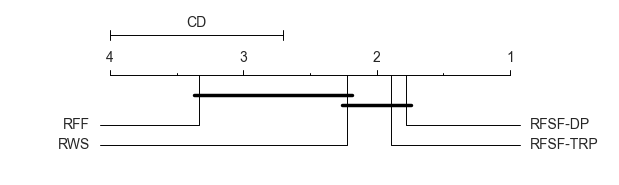

In [21]:
plots_dir = './plots/'
cd_diagram_fp = os.path.join(plots_dir, 'cd_diagram2.pdf')

cd = compute_CD(large_avg_rank, len(large_ds), alpha=0.1, test='bonferroni-dunn')
graph_ranks(large_avg_rank, df_large.columns, cd=cd, width=6, textspace=1, reverse=True, filename=cd_diagram_fp)

#### Box plot

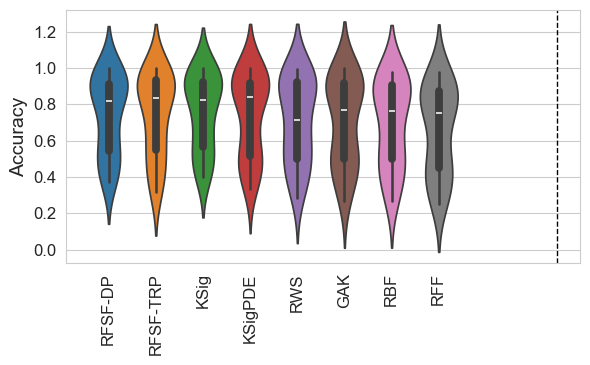

In [22]:
box_plot_fp = os.path.join(plots_dir, 'box_plot.pdf')

fig = plt.figure(figsize=(6, 3.75))
sns.violinplot(data=df.loc[small_ds].values)
plt.xticks(plt.xticks()[0], df.columns, rotation='vertical', fontsize=12)
plt.yticks(fontsize=12)
plt.axvline(x=9.5, color='black', linestyle='--', linewidth=1)
plt.ylabel('Accuracy', fontsize=14)
fig.patch.set_facecolor('white')
fig.tight_layout()
# fig.
plt.savefig(box_plot_fp, facecolor='white')